In [1]:
import numpy as np
import pandas as pd
from numpy.random import normal
from numpy.linalg import inv as inverse
from numpy.random import multivariate_normal as mvn
from scipy.interpolate import interp1d

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
%matplotlib inline

In [384]:
class KalmanFilter:
    def __init__(self, A, B, H, Q, R):
        self.A = A
        self.B = B
        self.H = H
        self.Q = Q
        self.R = R    
        
        # update the into matrix format
        self.update_variable()

    def update_variable(self):
        '''
        convert attributes to matrix format in case they are single numbers 
        or input as a list.
        '''
        for v in ['A', 'B', 'H', 'Q', 'R']:
            if isinstance(getattr(self, v), int) or isinstance(getattr(self, v), float):
                att = getattr(self, v)
                setattr(self, v, np.array([[att]]))

            if isinstance(getattr(self, v), list):
                att = getattr(self, v)
                setattr(self, v, np.array(att).reshape(len(att), -1))
        
    def predict(self, x, p, u):
        # type convert in case they are single numbers or input as a list.
        if isinstance(x, int) or isinstance(x, float):
            x = np.array([[x]])
        if isinstance(x, list):
            x = np.array(x).reshape(len(x), -1)
            
        if isinstance(p, int) or isinstance(p, float):
            p = np.array([[p]])
        if isinstance(x, list):
            p = np.array(u).reshape(len(p), -1)
            
        if isinstance(u, int) or isinstance(u, float):
            u = np.array([[u]])
        if isinstance(x, list):
            u = np.array(u).reshape(len(u), -1)
        
        # calculation
        x_ = np.dot(self.A, x) + np.dot(self.B, u)
        P_ = np.dot(np.dot(self.A, p), self.A.T) + self.Q
        
        return x_, P_
    
    def update(self, z, x_, P_):
        # convert obervation into matrix format
        if isinstance(z, int) or isinstance(z, float):
            z = np.array([[z]])
        if isinstance(z, list):
            z = np.array(z).reshape(len(z), -1)
        
        # the update process
        S = np.dot(np.dot(self.H, P_), self.H.T) + self.R
        K = np.dot(np.dot(P_, self.H.T), inverse(S))
        eps = z - np.dot(self.H, x_)
        
        x = x_ + np.dot(K, eps)
        P = P_ - np.dot(np.dot(K, self.H), P_)
        
        return x, P
    
    def tracking(self, z, x, p, u=0):
        x_, P_ = self.predict(x, p, u)
        x, P = self.update(z, x_, P_)
        return x_, P_, x, P
    
    def to_array(self, ds, pos):
        return np.array(list(map(lambda x: x.flatten()[pos], ds)))
    
    def filt(self, data, x, p, u=0):
        '''
        data: the data series needed to be filtered
        x: the initial states
        p: the initial covariance matrix of the state porcess
        u: control input for the state process
        '''
        updates, preds = [], []
        p_updates, p_preds = [], []
        for d in data:
            x_, P_, x, P = self.tracking(d, x, p, u=u)
            preds.append(x_)
            p_preds.append(P_)
            updates.append(x)
            p_updates.append(P)
        
        return updates, p_updates, preds, p_preds
            
        

# 2d case

In [697]:
n = 300
y = np.array([20, 30, 5, 12, 39, 48, 50, 3])
x = np.linspace(0, n, len(y))

interp = interp1d(x, y, kind='cubic')
x = np.linspace(1, n, n)
pos = interp(x)
obs = pos + normal(0, 4, len(pos))

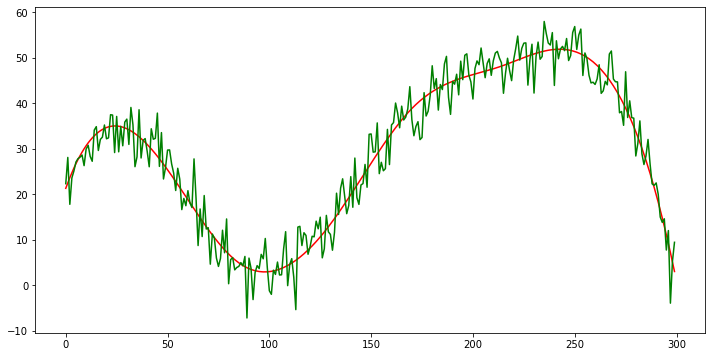

In [698]:
plt.figure(figsize=(12,6))
plt.plot(pos, color='red')
plt.plot(obs, color='green')

In [699]:
dt, var = 1, 2.35
A = [[1, dt], [0, 1]]
B = 0
Q = var * np.array([[.25 * dt ** 4, .5 * dt ** 3],
                    [.5 * dt ** 3, dt ** 2]])

H = [[1, 0]]
R = 500


kf = KalmanFilter(A, B, H, Q, R)
x, P = [0, 0], np.diag([10, 10])

updates, p_updates, preds, p_preds = kf.filt(obs, x, P)

In [700]:
updates = kf.to_array(updates, 0)
std = kf.to_array(p_updates, 0) **.5
up = updates + 2*std
down = updates - 2*std

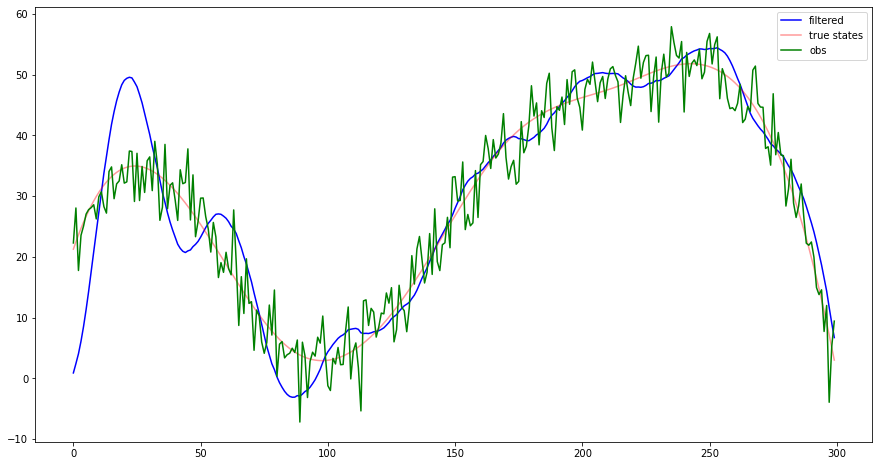

In [701]:
plt.figure(figsize=(15,8))
plt.plot(updates, color='blue', label='filtered')
plt.plot([x for x in range(n)], pos, color='red', label='true states', alpha=.4)
# plt.fill_between([x for x in range(n)], up, down, color='grey', alpha=.2)
plt.plot(obs, color='green', label='obs')
# plt.plot(preds, color='grey', label='preds')
plt.legend(loc='best')

# 1d case

In [612]:
n = 500
pos = [0]
for eps in normal(0, 1, n):
    pos += [pos[-1] + eps]

obs = [p + normal(0, 4, 1) for p in pos]

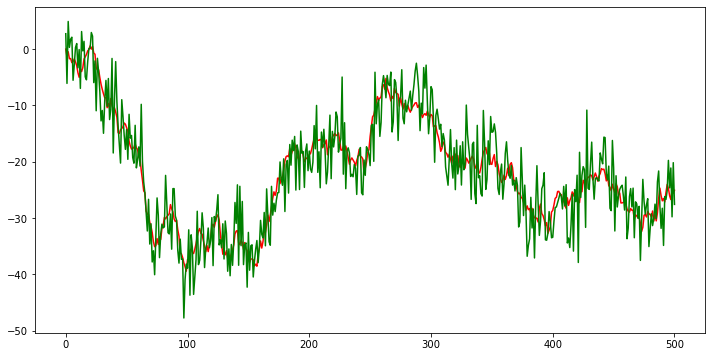

In [613]:
plt.figure(figsize=(12,6))
plt.plot(pos, color='red')
plt.plot(obs, color='green')

In [664]:
A = 1
B = 0
H = 1
Q = 1
R = 50


kf = KalmanFilter(A, B, H, Q, R)
preds, updates = [], []
p_preds, p_updates = [], []

x, P = 0, .25
for ob in obs:
    x_, P_, x, P = kf.tracking(ob, x, P)
    preds.append(x_)
    p_preds.append(P_)
    updates.append(x)
    p_updates.append(P)

updates = list(map(lambda x: x.flatten()[0], updates))

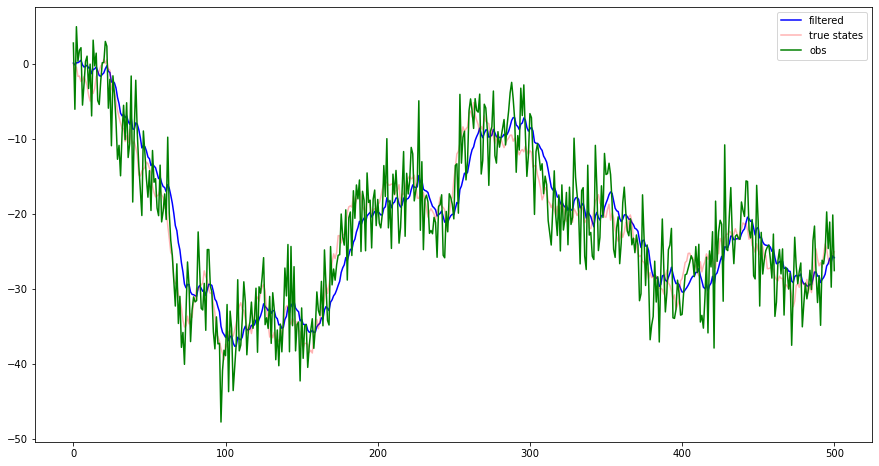

In [665]:
plt.figure(figsize=(15,8))
plt.plot(updates, color='blue', label='filtered')
plt.plot(pos, color='red', label='true states', alpha=.3)
plt.plot(obs, color='green', label='obs')
# plt.plot(preds, color='grey', label='preds')
plt.legend(loc='best')